# Detection de vissage

In [19]:
import cv2
import numpy
import matplotlib.pyplot as plt
import os
import numpy as np
import json

## A partir d'une image

On commence par chager l'image que l'on veut analyser.

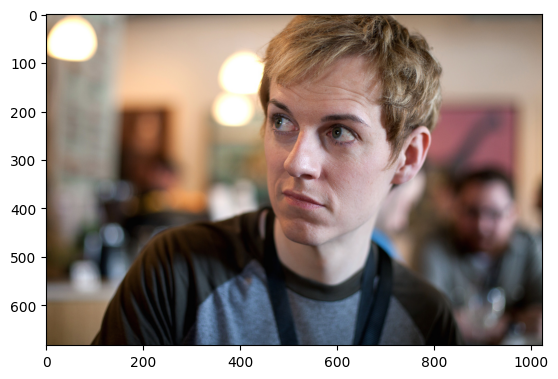

Dimensions de l'image : (683, 1024, 3)


In [3]:
# Charger l'image
image = cv2.imread('../assets/visage.jpg')

# Vérifier si l'image a été chargée
if image is not None:
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()
    # Vérifier les dimensions de l'image
    print('Dimensions de l\'image :', image.shape)
else:
    print("Failed to load the image.")

Ensuite on la change en noir et blanc pour faciliter la detection.

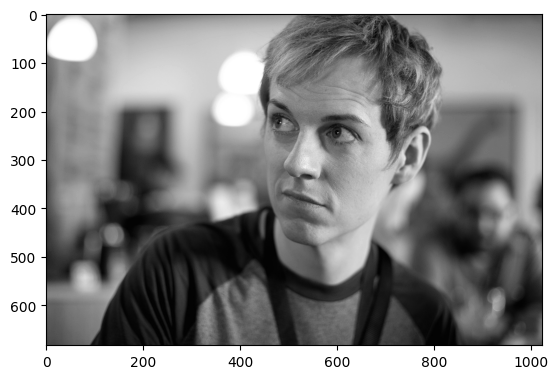

In [4]:
# Convertir l'image en niveaux de gris
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Afficher l'image en niveaux de gris
plt.imshow(gray_image, cmap='gray')
plt.show()

Puis on commence le code pour la detection.

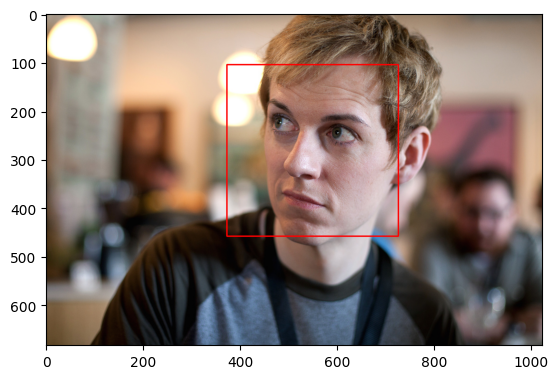

In [5]:
face_classifier = cv2.CascadeClassifier(
    cv2.data.haarcascades + "haarcascade_frontalface_default.xml"
)

face = face_classifier.detectMultiScale(
    gray_image, scaleFactor=1.1, minNeighbors=5, minSize=(40, 40)
)

# Pour chaque visage détecté
for (x, y, w, h) in face:
    # Dessiner un rectangle rouge avec une épaisseur de 2
    image_rectangle = cv2.rectangle(image.copy(), (x, y), (x+w, y+h), (0, 0, 255), 2)

# Afficher l'image
plt.imshow(cv2.cvtColor(image_rectangle, cv2.COLOR_BGR2RGB))
plt.show()

In [6]:
def detect_image(path_image, scale, minNeighbors, minSize):
    # Charger l'image
    image = cv2.imread(path_image)

    # Vérifier si l'image a été chargée
    if image is not None:
        #? plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        #? plt.show()
        print('Dimensions de l\'image :', image.shape)
    else:
        return "Erreur : L'image n'a pas pu être chargée."

    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Afficher l'image en niveaux de gris
    #? plt.imshow(gray_image, cmap='gray')
    #? plt.show()

    face_classifier = cv2.CascadeClassifier(
        cv2.data.haarcascades + "haarcascade_frontalface_default.xml"
    )

    face = face_classifier.detectMultiScale(
        gray_image, scaleFactor=scale, minNeighbors=minNeighbors, minSize=minSize
    )

    if len(face) > 0:
        print('Visage(s) détecté(s) :', len(face))
        image_rectangle = image.copy()
        coordonnees_visage = []

        # Pour chaque visage détecté
        for (x, y, w, h) in face:
            # Dessiner un rectangle rouge avec une épaisseur de 2
            image_rectangle = cv2.rectangle(image_rectangle, (x, y), (x+w, y+h), (0, 0, 255), 2)
            print('Coordonnées du visage :', (x, y, w, h))
            coordonnees_visage.append((x, y, w, h))
    else:
        print('Aucun visage détecté.')
        x,y,w,h = 0,0,0,0
        coordonnees_visage = [(x, y, w, h)]
        image_rectangle = image.copy()

    # Afficher l'image
    plt.imshow(cv2.cvtColor(image_rectangle, cv2.COLOR_BGR2RGB))
    plt.show()
    return path_image, len(face), coordonnees_visage

## Amelioration des hyperparametre

In [72]:
import cv2
import numpy as np
from sklearn.model_selection import GridSearchCV

id = "0a0d7a87378422e3"

# Exemple d'utilisation
image_path = '..\\assets\\archive\\images\\train\\{id}.jpg'
text_path = '..\\assets\\archive\\labels2\\{id}.txt'

# Charger l'image
X_train = cv2.imread(image_path.format(id=id))

# charger le fichier texte
with open(text_path.format(id=id), 'r') as file:
    y_train = file.read()


scale_factors = [1.01, 1.1, 1.2]
min_neighbors_list = [3, 5, 7, 10]
min_sizes = [(20,20),(30, 30), (40, 40)]


face_classifier = cv2.CascadeClassifier(
        cv2.data.haarcascades + "haarcascade_frontalface_default.xml"
    )

# Définir la grille d'hyperparamètres à tester
param_grid = {
    'scale_factors': scale_factors,
    'minNeighbors': min_neighbors_list,
    'minSize': min_sizes
}

# Initialiser GridSearchCV
grid_search = GridSearchCV(face_classifier, param_grid, cv=5, scoring='accuracy')

# Entraîner GridSearchCV
grid_search.fit(X_train, y_train)


# Afficher les meilleurs paramètres et le meilleur score
print("Meilleurs paramètres:", grid_search.best_params_)
print("Meilleur score:", grid_search.best_score_)

InvalidParameterError: The 'estimator' parameter of GridSearchCV must be an object implementing 'fit'. Got < cv2.CascadeClassifier 000002342E1A72F0> instead.

## A partir d'un webcam

In [7]:
#Lire à partir de la WebCam
video_capture = cv2.VideoCapture(0)

# Charger le classificateur en cascade Haar pour les visages
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Capturer le flux vidéo de la webcam
cap = cv2.VideoCapture(0)

while True:
    # Lire une image du flux vidéo
    ret, img = cap.read()

    # Convertir en niveaux de gris
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Détecter les visages
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)

    # Dessiner un rectangle autour de chaque visage détecté
    for (x,y,w,h) in faces:
        cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)

    # Afficher l'image résultante
    cv2.imshow('img',img)

    # Quitter si 'q' est pressé
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Libérer la capture vidéo et fermer toutes les fenêtres
cap.release()
cv2.destroyAllWindows()

## Evaluer les performances

In [8]:
def calculer_iou(box1, box2):
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2

    # Calculer les coordonnées des zones d'intersection
    xi1 = max(x1, x2)
    yi1 = max(y1, y2)
    xi2 = min(x1 + w1, x2 + w2)
    yi2 = min(y1 + h1, y2 + h2)
    inter_area = max(0, xi2 - xi1) * max(0, yi2 - yi1)

    # Calculer les zones des boîtes englobantes
    box1_area = w1 * h1
    box2_area = w2 * h2

    # Calculer l'IoU
    union_area = box1_area + box2_area - inter_area
    iou = inter_area / union_area

    return iou

In [9]:
def filtrer_carres_proches(liste_coordonnees, seuil_proximite):
    """
    Filtrer les carrés trop proches en ne conservant que le plus grand lorsque deux carrés sont à moins
    d'une certaine distance l'un de l'autre.

    :param liste_coordonnees: Liste des coordonnées des carrés sous la forme [(x, y, largeur, hauteur), ...]
    :param seuil_proximite: Distance maximale pour considérer deux carrés comme étant "proches"
    :return: Liste filtrée des coordonnées
    """
    def calculer_surface(carre):
        _, _, largeur, hauteur = carre
        return largeur * hauteur

    # Trier les carrés par leur position x, puis y pour la comparaison
    liste_triee = sorted(liste_coordonnees, key=lambda x: (x[0], x[1]))

    # Liste pour stocker les carrés après filtrage
    resultat_filtré = []

    while liste_triee:
        carre = liste_triee.pop(0)
        carres_a_comparer = []

        # Trouver les carrés proches du carré actuel
        for autre_carre in liste_triee:
            if abs(carre[0] - autre_carre[0]) <= seuil_proximite and abs(carre[1] - autre_carre[1]) <= seuil_proximite:
                carres_a_comparer.append(autre_carre)

        # Comparer les surfaces des carrés proches et ne garder que le plus grand
        for carre_proche in carres_a_comparer:
            if calculer_surface(carre) >= calculer_surface(carre_proche):
                # Si le carré actuel est plus grand, on le garde et on retire le plus petit
                liste_triee.remove(carre_proche)
            else:
                # Si le carré proche est plus grand, on remplace le carré actuel par le plus grand
                carre = carre_proche
                liste_triee.remove(carre_proche)

        resultat_filtré.append(carre)

    return resultat_filtré

Image choisie : ../assets/archive/images/train/7c888dfa664469c8.jpg
Texte associé : ../assets/archive/labels2/7c888dfa664469c8.txt
Contenu du fichier texte :
Human face 0.0 109.562079 10.24 162.10048799999998
Human face 24.96 403.648902 51.2 435.044363
Human face 94.08 551.653636 130.56 581.767106
Human face 126.08 77.525964 149.76 122.375842
Human face 133.76 303.69799900000004 160.0 324.84163
Human face 177.28 118.531918 204.8 146.082772
Human face 266.24 279.99175199999996 288.64 298.57208399999996
Human face 336.0 60.22694 378.24 118.531918
Human face 362.88 597.785505 515.2 682.359346
Human face 373.76 442.732894 410.24 456.18731099999997
Human face 376.32 310.10522199999997 389.76 326.12293800000003
Human face 443.52 86.496486 485.76 140.316203
Human face 494.72 271.02191300000004 538.88 304.979307
Human face 502.4 345.985261 541.44 372.254124
Human face 507.52 458.75061 548.48 474.127672
Human face 551.68 62.789556 606.72 114.046657
Human face 586.24 398.52367 615.04 410.056125


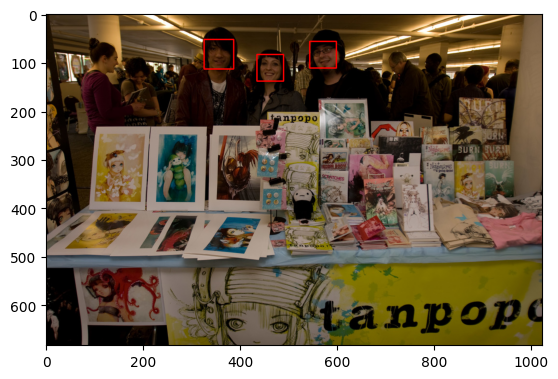

IoU : 0.0
(0.0, 109.562079, 10.24, 52.53840899999999) (326, 52, 61, 61)
 
IoU : 0.0
(24.96, 403.648902, 26.240000000000002, 31.395460999999955) (435, 83, 55, 55)
 
IoU : 0.0
(94.08, 551.653636, 36.480000000000004, 30.113470000000007) (544, 56, 55, 55)
 
[(326, 52, 61, 61), (435, 83, 55, 55), (544, 56, 55, 55)]


([(326, 52, 61, 61), (435, 83, 55, 55), (544, 56, 55, 55)],
 [(0.0, 109.562079, 10.24, 52.53840899999999),
  (24.96, 403.648902, 26.240000000000002, 31.395460999999955),
  (94.08, 551.653636, 36.480000000000004, 30.113470000000007),
  (126.08, 77.525964, 23.679999999999993, 44.849878000000004),
  (133.76, 303.69799900000004, 26.24000000000001, 21.14363099999997),
  (177.28, 118.531918, 27.52000000000001, 27.550854),
  (266.24, 279.99175199999996, 22.399999999999977, 18.580332),
  (336.0, 60.22694, 42.24000000000001, 58.304978000000006),
  (362.88, 597.785505, 152.32000000000005, 84.57384100000002),
  (373.76, 442.732894, 36.48000000000002, 13.454416999999978),
  (376.32, 310.10522199999997, 13.439999999999998, 16.017716000000064),
  (443.52, 86.496486, 42.24000000000001, 53.819717),
  (494.72, 271.02191300000004, 44.15999999999997, 33.957393999999965),
  (502.4, 345.985261, 39.04000000000008, 26.26886300000001),
  (507.52, 458.75061, 40.960000000000036, 15.377062000000024),
  (551.68, 

In [65]:
path_images = '../assets/archive/images/train/'
path_texts = '../assets/archive/labels2/'

# Choisir une image aléatoire dans le dossier
liste_images = os.listdir(path_images)
liste_text = os.listdir(path_texts)

index = numpy.random.randint(0, len(liste_images))
#index = 0

def analyse_image(index, proximite=0):

    path_image = os.path.join(path_images, liste_images[index])
    path_text = os.path.join(path_texts, liste_images[index].replace('.jpg', '.txt'))
    print('Image choisie :', path_image)
    print('Texte associé :', path_text)

    # Afficher le contenue du fichier text
    with open(path_text, 'r', encoding='utf-8') as fichier:
        # Lire le contenu du fichier
        contenu = fichier.read()
        # Afficher le contenu
        print('Contenu du fichier texte :')
        print(contenu)


    result = detect_image(path_image, 1.2, 5, (40, 40))
    result_trie = sorted(result[2], key=lambda x: x[0])

    if proximite > 0:
        result_trie = filtrer_carres_proches(result_trie, proximite)

    _box = []

    for lines in contenu.split('\n'):
        if lines == '':
            continue
        lines = lines.replace('Human face','')
        lines = lines.split(' ')
        x, y, w, h = float(lines[1]), float(lines[2]), float(lines[3]), float(lines[4])
        #print((x, y, w-x, h-y))
        _box.append((x, y, w-x, h-y))

    _box_trie = sorted(_box, key=lambda x: x[0])

    if len(_box_trie) > len(result_trie):
        value = len(result_trie)
    else:
        value = len(_box_trie)

    list_iou = []

    for box in range(value):
        iou = calculer_iou(_box_trie[box], result_trie[box])
        print('IoU :', iou)
        print(_box_trie[box], result_trie[box])
        print(" ")
        list_iou.append(iou)

    print(result_trie)

    return result_trie, _box_trie, iou, result[0]

analyse_image(index)

Image n° 0
Image choisie : ../assets/archive/images/train/00006c07d2b033d1.jpg
Texte associé : ../assets/archive/labels2/00006c07d2b033d1.txt
Contenu du fichier texte :
Human face 332.8 235.199488 475.200512 432.0
Human face 609.599488 227.2 755.2 420.799488

Dimensions de l'image : (1024, 1024, 3)
Visage(s) détecté(s) : 2
Coordonnées du visage : (597, 237, 166, 166)
Coordonnées du visage : (332, 246, 170, 170)


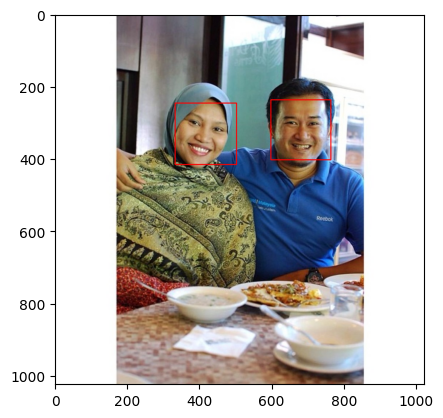

IoU : 0.7399372221187623
(332.8, 235.199488, 142.400512, 196.800512) (332, 246, 170, 170)
 
IoU : 0.7654811734355523
(609.599488, 227.2, 145.6005120000001, 193.599488) (597, 237, 166, 166)
 
[(332, 246, 170, 170), (597, 237, 166, 166)]
Image n° 1
Image choisie : ../assets/archive/images/train/0000bee39176697a.jpg
Texte associé : ../assets/archive/labels2/0000bee39176697a.txt
Contenu du fichier texte :
Human face 186.24 249.80592399999998 266.24 354.85306199999997
Human face 322.56 175.50507000000002 410.24 297.205597
Human face 641.28 104.405924 767.36 273.505397

Dimensions de l'image : (727, 1024, 3)
Visage(s) détecté(s) : 3
Coordonnées du visage : (172, 253, 98, 98)
Coordonnées du visage : (226, 510, 53, 53)
Coordonnées du visage : (301, 175, 115, 115)


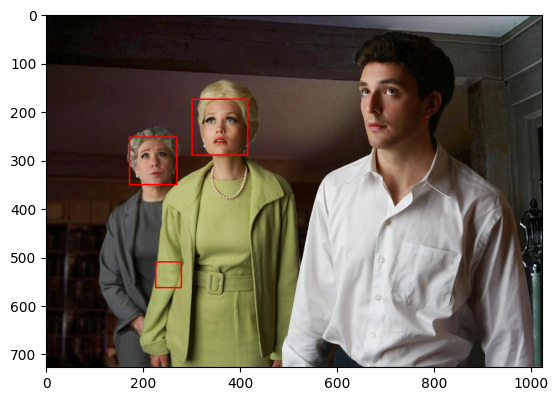

IoU : 0.7710637827265631
(186.24, 249.80592399999998, 80.0, 105.04713799999999) (172, 253, 98, 98)
 
IoU : 0.0
(322.56, 175.50507000000002, 87.68, 121.700527) (226, 510, 53, 53)
 
IoU : 0.0
(641.28, 104.405924, 126.08000000000004, 169.09947300000002) (301, 175, 115, 115)
 
[(172, 253, 98, 98), (226, 510, 53, 53), (301, 175, 115, 115)]
Image n° 2
Image choisie : ../assets/archive/images/train/0000eda1171fe14e.jpg
Texte associé : ../assets/archive/labels2/0000eda1171fe14e.txt
Contenu du fichier texte :
Human face 81.28 363.595016 106.88 388.560724
Human face 400.64 581.2403439999999 450.56 646.533788
Human face 488.96 525.549036 537.6 595.323168
Human face 785.92 558.836132 836.48 681.10086
Human face 842.88 389.84069999999997 892.16 439.131356

Dimensions de l'image : (772, 1024, 3)
Visage(s) détecté(s) : 2
Coordonnées du visage : (501, 537, 57, 57)
Coordonnées du visage : (852, 389, 53, 53)


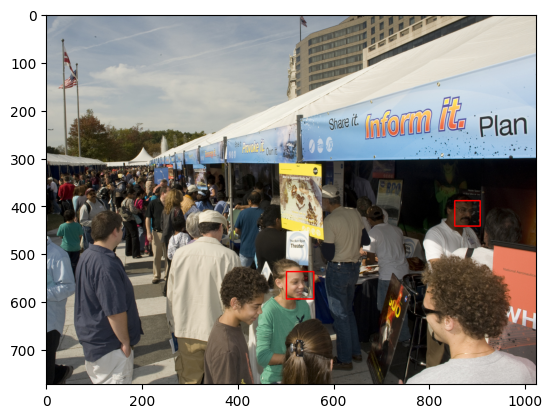

IoU : 0.0
(81.28, 363.595016, 25.599999999999994, 24.965708000000006) (501, 537, 57, 57)
 
IoU : 0.0
(400.64, 581.2403439999999, 49.920000000000016, 65.29344400000002) (852, 389, 53, 53)
 
[(501, 537, 57, 57), (852, 389, 53, 53)]
Image n° 3
Image choisie : ../assets/archive/images/train/00090bdd55ec42c3.jpg
Texte associé : ../assets/archive/labels2/00090bdd55ec42c3.txt
Contenu du fichier texte :
Human face 344.98908 172.372992 478.20218400000005 342.187008

Dimensions de l'image : (1024, 684, 3)
Visage(s) détecté(s) : 1
Coordonnées du visage : (339, 162, 161, 161)


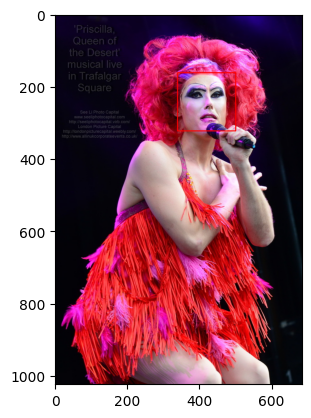

IoU : 0.7046219348302061
(344.98908, 172.372992, 133.21310400000004, 169.81401599999998) (339, 162, 161, 161)
 
[(339, 162, 161, 161)]
Image n° 4
Image choisie : ../assets/archive/images/train/000d1eae99343db8.jpg
Texte associé : ../assets/archive/labels2/000d1eae99343db8.txt
Contenu du fichier texte :
Human face 196.44136699999999 246.4 568.848675 836.48

Dimensions de l'image : (1024, 613, 3)
Aucun visage détecté.


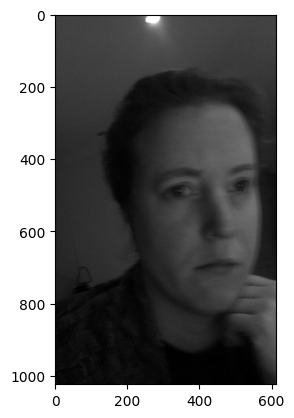

IoU : 0.0
(196.44136699999999, 246.4, 372.40730799999994, 590.08) (0, 0, 0, 0)
 
[(0, 0, 0, 0)]
Image n° 5
Image choisie : ../assets/archive/images/train/001065b2a612f5ad.jpg
Texte associé : ../assets/archive/labels2/001065b2a612f5ad.txt
Contenu du fichier texte :
Human face 263.29699800000003 62.08 374.765256 213.76

Dimensions de l'image : (1024, 738, 3)
Visage(s) détecté(s) : 2
Coordonnées du visage : (246, 65, 138, 138)
Coordonnées du visage : (643, 331, 85, 85)


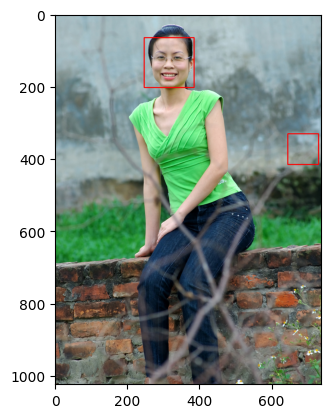

IoU : 0.7478586723863555
(263.29699800000003, 62.08, 111.46825799999999, 151.68) (246, 65, 138, 138)
 
[(246, 65, 138, 138), (643, 331, 85, 85)]
Image n° 6
Image choisie : ../assets/archive/images/train/00134c19ee564cad.jpg
Texte associé : ../assets/archive/labels2/00134c19ee564cad.txt
Contenu du fichier texte :
Human face 273.28 190.07999999999998 491.52 493.43999999999994

Dimensions de l'image : (768, 1024, 3)
Visage(s) détecté(s) : 1
Coordonnées du visage : (301, 214, 224, 224)


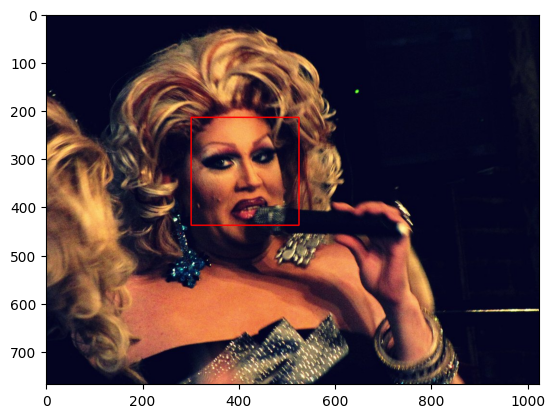

IoU : 0.5790189552685671
(273.28, 190.07999999999998, 218.24, 303.35999999999996) (301, 214, 224, 224)
 
[(301, 214, 224, 224)]
Image n° 7
Image choisie : ../assets/archive/images/train/00143d27992ccf33.jpg
Texte associé : ../assets/archive/labels2/00143d27992ccf33.txt
Contenu du fichier texte :
Human face 0.0 489.59999999999997 60.8 564.0
Human face 300.000256 202.400256 551.999488 601.599744
Human face 640.0 108.0 888.800256 474.39974400000006

Dimensions de l'image : (768, 1024, 3)
Visage(s) détecté(s) : 2
Coordonnées du visage : (600, 140, 313, 313)
Coordonnées du visage : (281, 208, 318, 318)


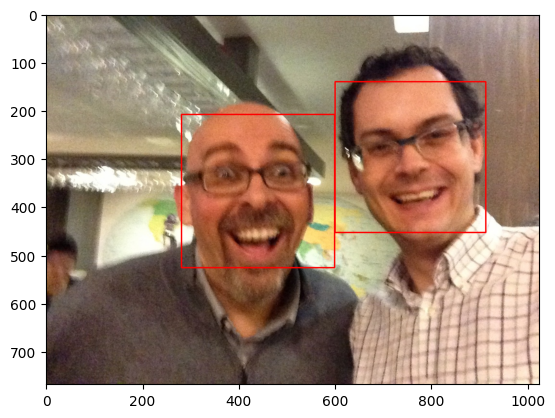

IoU : 0.0
(0.0, 489.59999999999997, 60.8, 74.40000000000003) (281, 208, 318, 318)
 
IoU : 0.0
(300.000256, 202.400256, 251.99923200000006, 399.199488) (600, 140, 313, 313)
 
[(281, 208, 318, 318), (600, 140, 313, 313)]
Image n° 8
Image choisie : ../assets/archive/images/train/0014d30877173ab7.jpg
Texte associé : ../assets/archive/labels2/0014d30877173ab7.txt
Contenu du fichier texte :
Human face 89.6 63.528385 193.28 192.50997900000002

Dimensions de l'image : (317, 1024, 3)
Aucun visage détecté.


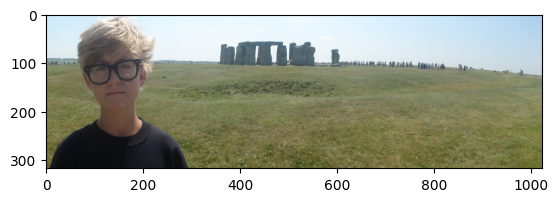

IoU : 0.0
(89.6, 63.528385, 103.68, 128.98159400000003) (0, 0, 0, 0)
 
[(0, 0, 0, 0)]
Image n° 9
Image choisie : ../assets/archive/images/train/0019f8ef73bbe608.jpg
Texte associé : ../assets/archive/labels2/0019f8ef73bbe608.txt
Contenu du fichier texte :
Human face 547.2 396.800256 748.8 652.8

Dimensions de l'image : (768, 1024, 3)
Aucun visage détecté.


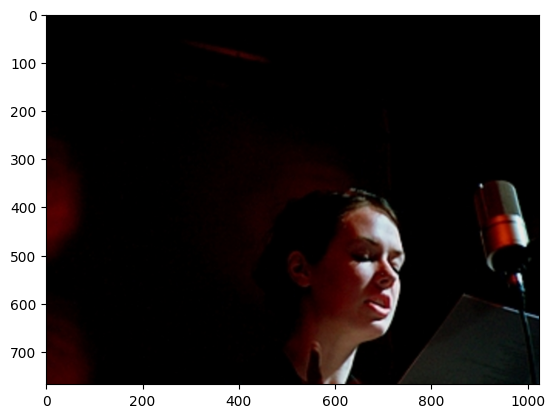

IoU : 0.0
(547.2, 396.800256, 201.5999999999999, 255.99974399999996) (0, 0, 0, 0)
 
[(0, 0, 0, 0)]


In [66]:
import json
import numpy as np

dictionnaire = {}

for i in range(10):
    print('Image n°', i)
    coordonee_detecte, coordonnee_reel, iou, path_image = analyse_image(i)
    humanliste = {}
    for i in range(len(coordonee_detecte)-1):
        humanliste[f"Human{i}"] = coordonnee_reel[i]
    dictionnaire[path_image] = {"coordonnee_detectee": humanliste,
                                'coordonnee_reel': coordonnee_reel,
                                'iou': iou}

# Convert int32 values to int
dictionnaire_fixed = {k: {k2: np.array(v2).tolist() if isinstance(v2, np.ndarray) else v2 for k2, v2 in v.items()} for k, v in dictionnaire.items()}

# Serialize the fixed dictionary to JSON
with open('resultats_analyse.json', 'w') as fichier_json:
    json.dump(dictionnaire_fixed, fichier_json, indent=4)

Counter({0.0: 6, 0.7654811734355523: 1, 0.7046219348302061: 1, 0.7478586723863555: 1, 0.5790189552685671: 1})
La moyenne de l'IoU est de :  0.2796980735920681


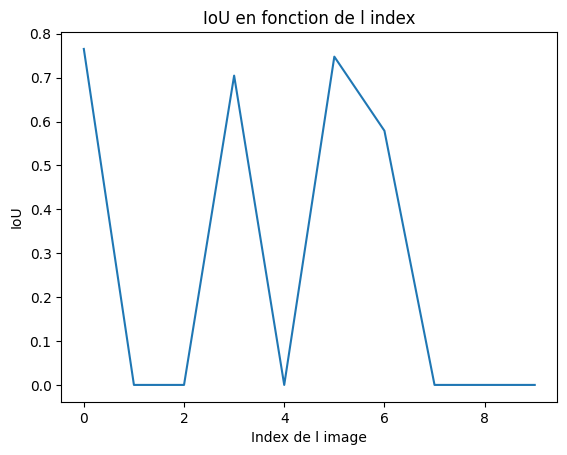

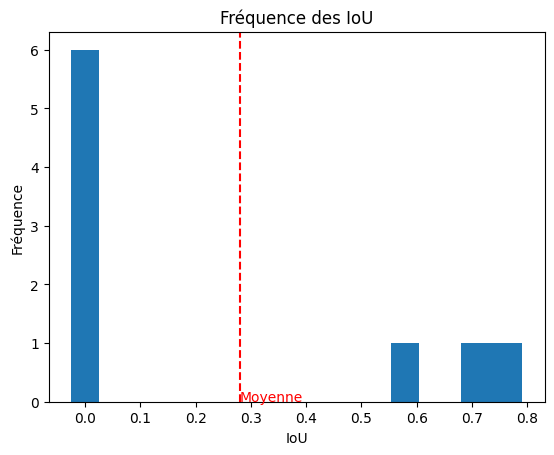

In [70]:
from collections import Counter

#? Reprend le fichier JSON et affiche le ioU sout forme graphique

zero_compris = True

json_file = "resultats_analyse.json"

with open(json_file, 'r') as fichier_json:
    data = json.load(fichier_json)

# parcour l'ensemble des object du fichier
iou_list = []
for key, value in data.items():
    if value['iou'] == 0 and zero_compris == False:
        continue
    else:
        iou_list.append(value['iou'])

frequence_iou = Counter(iou_list)
print(frequence_iou)

# print moyenne de l'iou de l'ensemble des images
print("La moyenne de l'IoU est de : ", np.mean(iou_list))

# Affiche le graphique
plt.plot(iou_list)
plt.xlabel('Index de l image')
plt.ylabel('IoU')
plt.title('IoU en fonction de l index')
plt.show()

# Affiche le graphique
plt.bar(frequence_iou.keys(), frequence_iou.values(), 0.05)
plt.xlabel('IoU')
plt.ylabel('Fréquence')
plt.title('Fréquence des IoU')

# Trace une ligne rouge à la moyenne
plt.axvline(x=np.mean(iou_list), color='red', linestyle='--')
plt.text(np.mean(iou_list), 0, 'Moyenne', color='red')
plt.show()

